We must prepare our data first. Some recordings are not exactly 1s long or are not normalized.
In this notebook we load all recordings, fix their length, normalize them and finally mix them with the background noise, sometimes (like for the target word) we do this several times.

First things first. Importing all libraries.

In [3]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.python.ops import gen_audio_ops
import python_speech_features

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import librosa as rosa

from IPython.display import display, Audio, HTML
from tqdm.notebook import tqdm

import random
import os

print(f"Tensorflow v{tf.__version__}")

Tensorflow v2.12.0


Then we iterate through out data directory and read all of the words names.

In [4]:
DATA_DIR = os.path.join(".", "data")
words = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d)) and not d.startswith("_")]
print(words)

TARGET_WORD = "komputer"
OTHER_WORD = "other"

commands = [TARGET_WORD, OTHER_WORD, "noise", "talking"]

others = list(filter(lambda w: w != TARGET_WORD, words))
target = [TARGET_WORD]

labels = [TARGET_WORD, OTHER_WORD]

['right', 'eight', 'cat', 'tree', 'backward', 'learn', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'follow', 'nine', 'left', 'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'visual', 'komputer', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'forward', 'off', 'four']


Prepare some utility functions for audio processing.
First constants used in these functions:

In [5]:
#Audio sample rate
SAMPLE_RATE = 16000

# Window size and step for STFT
WINDOW_SIZE = 320
WINDOW_STEP = 160
WINDOW_LENGTH_IN_MS = WINDOW_SIZE / SAMPLE_RATE
WINDOW_STEP_IN_MS = WINDOW_STEP / SAMPLE_RATE

# Configuration for different audio processing methods
NO_AUDIO_SHIFTS = 2
NO_BG_MIXED = 1
NO_FREQ_MASK_SPECS = 1
NO_TIME_MASK_SPECS = 1
MASK_MAX_WIDTH = 6
VOICE_THRESHOLD = 0.2
BG_VOLUME = 0.1
POOLING_SIZE = [1, 6]

# Constants
MINUTE_SAMPLE = 60 * SAMPLE_RATE
PLOT_SIZE = (10, 4)

# Enable debug
DEBUG = True

Then functions used for debugging generated samples. And the function to generate spectrogram.

In [55]:
def plot_audio(audio, ax=None, desc=None):
    if not DEBUG:
        return

    if desc is not None:
        display(HTML(f'<h1><center>{desc}</center></h1>'))
    
    axe = ax
    if ax is None:
        _, axe = plt.subplots(figsize=PLOT_SIZE)

    axe.plot(audio)
    axe.set_title('Audio wave')
    axe.set_xlabel('Time')
    axe.set_ylabel('Amplitude')
    
    if ax is None:
        plt.show()


def plot_spec(spec, ax=None, desc=None):
    if not DEBUG:
        return

    if desc is not None:
        display(HTML(f'<h1><center>{desc}</center></h1>'))

    axe = ax
    if ax is None:
        _, axe = plt.subplots(figsize=PLOT_SIZE)

    spec = np.squeeze(spec)
#     spec = np.rot90(spec, axes=(1,0))

    im = axe.imshow(spec, aspect='auto', origin='lower', cmap='jet')
    axe.figure.colorbar(im, ax=axe, label='Magnitude')
    axe.set_title('Spectrogram')
    axe.set_xlabel('Time')
    axe.set_ylabel('Frequency')
    
    if ax is None:
        plt.show()


def plot_mfcc(mfcc, ax=None, desc=None):
    if not DEBUG:
        return

    if desc is not None:
        display(HTML(f'<h1><center>{desc}</center></h1>'))

    axe = ax
    if ax is None:
        _, axe = plt.subplots(figsize=PLOT_SIZE)

    im = axe.imshow(mfcc, aspect='auto', origin='lower', cmap='hot')
    axe.figure.colorbar(im, ax=axe, label='Coefficient')
    axe.set_title('MFCC')
    axe.set_xlabel('Frame')
    axe.set_ylabel('Channel')
    
    if ax is None:
        plt.show()


def debug_audio(audio, desc='Audio', feature_type='spec'):
    if not DEBUG:
        return

    display(HTML(f'<h1><center>{desc}</center></h1>'))
    fig, axes = plt.subplots(1, 2, figsize=PLOT_SIZE)
    
    if feature_type == 'mfcc':
        mfcc = get_mfcc(audio)
        plot_mfcc(mfcc, ax=axes[1])
    elif feature_type == 'spec':
        spec = get_spectrogram(audio)
        plot_spec(spec, ax=axes[1])

    plot_audio(audio, ax=axes[0])
    display(Audio(audio, rate=SAMPLE_RATE))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()


def get_spectrogram(audio):
    """
        Generate a spectrogram for a given audio. Then apply pooling to reduce dimensions.
    """
    
    audio = cure_audio(audio)
    audio = tf.expand_dims(audio, -1)
    audio = tf.cast(audio[:], tf.float32)

    spec = gen_audio_ops.audio_spectrogram(audio,
                                           window_size=WINDOW_SIZE,
                                           stride=WINDOW_STEP,
                                           magnitude_squared=True).numpy()

    spec = tf.expand_dims(spec, -1)
    spec = tf.nn.pool(input=spec,
                      window_shape=POOLING_SIZE,
                      strides=POOLING_SIZE,
                      pooling_type='AVG',
                      padding='SAME')
    spec = tf.squeeze(spec, axis=0)
    spec = np.log(spec + np.finfo(float).eps)
    return spec


def get_mfcc(audio):
    audio = cure_audio(audio)
    audio = tf.cast(audio[:], tf.float32)
    mfcc = python_speech_features.mfcc(audio)
    mfcc = np.expand_dims(mfcc, -1)
#     mfcc = rosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=32, n_mels=16)
#     mfcc = rosa.util.normalize(mfcc)
    return mfcc



And finally all the audio processing functions:

In [7]:
def begin_voice(audio):
    """
        Move voice to the beginning of the recording.
    """
    start, end = find_voice(audio)
    start = max(0, start - 100)
    end = min(SAMPLE_RATE, end + 100)
    return cure_audio(audio[start:end])


def find_voice(audio):
    """
        Find voice start and end points in the audio.
    """

    audio_abs = np.abs(audio)
    start = np.argmax(audio_abs > VOICE_THRESHOLD)
    end = len(audio_abs) - np.argmax(audio_abs[::-1] > VOICE_THRESHOLD) - 1
    return start, end


def time_stretch_audio(audios, r):
    """
        Speed up or slow down provided audios by a given rate.
    """

    res = []
    for a in audios:
        copy = rosa.effects.time_stretch(a, rate=r)
        copy = cure_audio(copy)
        res.append(copy)
        debug_audio(copy, desc=f'Time stretched audio by rate {r}')
    return res


def pitch_shift_audio(audios, s):
    """
        Shift pitch by the given number of half-tones in provided audios.
    """

    res = []
    for a in audios:
        copy = rosa.effects.pitch_shift(a, sr=SAMPLE_RATE, n_steps=s)
        copy = cure_audio(copy)
        res.append(copy)
        debug_audio(copy, desc=f'Pitch shifted audio by {s} half-tones')
    return res


def mix_audio(audios):
    """
        Mix provided audios with background noise samples.
    """

    res = []
    for a in audios:
        for i in range(NO_AUDIO_SHIFTS):
            noise = bg_noises[random.randint(0, len(bg_noises) - 1)]
            noise_start = random.randint(0, len(noise) - SAMPLE_RATE)
            noise = noise[noise_start:noise_start + SAMPLE_RATE]
            copy = a + noise
            copy = cure_audio(copy)
            res.append(copy)
            debug_audio(copy, desc="Audio mixed with noise")
    return res


def shift_audio(audios):
    """
        Shifts voice in provided audios.
    """

    res = []
    for a in audios:
        start, end = find_voice(a)
        silence_len = len(a) + start - end
        silence_interval = silence_len // NO_AUDIO_SHIFTS
        for i in range(NO_AUDIO_SHIFTS):
            shift = (i + 1) * silence_interval
            shift = shift - start if shift > start else -shift
            copy = np.roll(a, shift)
            copy = cure_audio(copy)
            res.append(copy)
            debug_audio(copy, desc=f"Audio shifted by {shift} samples")
    return res


def freq_mask(spec, value=None, width=MASK_MAX_WIDTH):
    """
        Add the mean-value mask to the frequency dimension of the spectrogram.
    """

    if value is None:
        value = spec.mean()
        
    copy = spec.copy()
    mel_channels = copy.shape[1]
    w = random.randint(1, width)
    f_start = random.randint(0, mel_channels - w)
    f_end = random.randint(f_start + 1, f_start + w)
    copy[:, f_start:f_end, :] = value
    plot_spec(copy, desc="Frequency masked spectrogram")
    return copy


def time_mask(spec, value=None, width=MASK_MAX_WIDTH):
    """
        Add the zero mask to the frequency dimension of the spectrogram.
    """

    if value is None:
        value = spec.mean()

    copy = spec.copy()
    time_channels = copy.shape[0]
    w = random.randint(1, width)
    t_start = random.randint(0, time_channels - w)
    t_end = random.randint(t_start + 1, t_start + w)
    copy[t_start:t_end, :, :] = value
    plot_spec(copy, desc="Time masked spectrogram")
    return copy


def normalize_audio(audio):
    """
        Normalize audio.
    """

    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return audio


def cut_audio_length(audio, length=SAMPLE_RATE):
    """
        Cut audio to SAMPLE_RATE length.
    """

    audio_len = len(audio)
    if audio_len < length:
        audio = np.append(audio, np.zeros(length - audio_len))
    audio = audio[:length]
    return audio


def cure_audio(audio):
    """
        Make sure that audio's length is fixed to SAMPLE_RATE and normalize.
    """

    audio = cut_audio_length(audio)
    audio = normalize_audio(audio)
    return np.array(audio)



Loading all the background noise samples to the memory. We will mix them with actual voice recordings.

In [25]:
BG_NOISE_DIR = os.path.join(DATA_DIR, "_bgnoise")
bg_noise_files = [f for f in os.listdir(BG_NOISE_DIR) if f.endswith(".wav")]
bg_noises = []

for file_name in bg_noise_files:
    file_path = os.path.join(BG_NOISE_DIR, file_name)
    audio, _ = rosa.load(file_path, sr=SAMPLE_RATE, mono=True)
#     audio = cut_audio_length(audio, 1 * MINUTE_SAMPLE)
    audio = normalize_audio(audio)
    audio = BG_VOLUME * audio
    debug_audio(audio, desc=f"Background noise [{file_name}]")
    bg_noises.append(audio)



Main function to process each voice sample.

In [8]:
def process_file(file_path, label, additional=True):
    """
        Process a file sample by adding more filters to all the samples generated in previous steps.
    """

    # Read the original file
    audio, _ = rosa.load(file_path, sr=SAMPLE_RATE, mono=True)
    audio = cure_audio(audio) #begin_voice(audio)
    debug_audio(audio, desc=f"Pure audio [{os.path.basename(file_path)}]")
    
    # Audio processing
    samples = [audio]
    if additional:
        
        # stretch audio
        stretched = []
        for r in [0.8, 0.9, 1.1, 1.2]:
            stretched += time_stretch_audio(samples, r)
        samples += stretched

        # pitch audio
        pitched = []
        for s in [-2, -1, 1, 2]:
            pitched += pitch_shift_audio(samples, s)
        samples += pitched

        # shift audio
        shifted = shift_audio(samples)
        samples += shifted

        # mix with background noise
        bg_mixxx = mix_audio(samples)
        samples += bg_mixxx

    specs = []
    for s in samples:
        spec = get_spectrogram(s)
        specs.append(spec)

        for i in range(NO_FREQ_MASK_SPECS):
            specs.append(freq_mask(spec))

        for i in range(NO_TIME_MASK_SPECS):
            specs.append(time_mask(spec))

    if DEBUG:
        print(f"Generated {len(specs)} different samples of provided audio")

    return [(s, label) for s in specs]



In [16]:
DEBUG=False
# Test for single audio file
word_dir = os.path.join(DATA_DIR, TARGET_WORD)
recordings = [f for f in os.listdir(word_dir) if f.endswith(".wav")]
random.shuffle(recordings)
file_path = os.path.join(word_dir, recordings[0])
specs = process_file(file_path, label=0)

print(specs[0][0].shape)
print(f"Samples per file: {len(specs)}")

(99, 43, 1)
Samples per file: 675


In [17]:
specs = []

for w in others:
    word_dir = os.path.join(DATA_DIR, w)
    files = [f for f in os.listdir(word_dir) if f.endswith(".wav")]
    with tqdm(total=len(files), desc=w) as progress_bar:
        for f in files:
            file_path = os.path.join(word_dir, f)
            specs += process_file(file_path, label=1, additional=False)
            progress_bar.update()



right:   0%|          | 0/3778 [00:00<?, ?it/s]

eight:   0%|          | 0/3787 [00:00<?, ?it/s]

cat:   0%|          | 0/2031 [00:00<?, ?it/s]

tree:   0%|          | 0/1759 [00:00<?, ?it/s]

backward:   0%|          | 0/1664 [00:00<?, ?it/s]

learn:   0%|          | 0/1575 [00:00<?, ?it/s]

bed:   0%|          | 0/2014 [00:00<?, ?it/s]

happy:   0%|          | 0/2054 [00:00<?, ?it/s]

go:   0%|          | 0/3880 [00:00<?, ?it/s]

dog:   0%|          | 0/2128 [00:00<?, ?it/s]

no:   0%|          | 0/3941 [00:00<?, ?it/s]

wow:   0%|          | 0/2123 [00:00<?, ?it/s]

follow:   0%|          | 0/1579 [00:00<?, ?it/s]

nine:   0%|          | 0/3934 [00:00<?, ?it/s]

left:   0%|          | 0/3801 [00:00<?, ?it/s]

stop:   0%|          | 0/3872 [00:00<?, ?it/s]

three:   0%|          | 0/3727 [00:00<?, ?it/s]

sheila:   0%|          | 0/2022 [00:00<?, ?it/s]

one:   0%|          | 0/3890 [00:00<?, ?it/s]

bird:   0%|          | 0/2064 [00:00<?, ?it/s]

zero:   0%|          | 0/4052 [00:00<?, ?it/s]

seven:   0%|          | 0/3998 [00:00<?, ?it/s]

up:   0%|          | 0/3723 [00:00<?, ?it/s]

visual:   0%|          | 0/1592 [00:00<?, ?it/s]

marvin:   0%|          | 0/2100 [00:00<?, ?it/s]

two:   0%|          | 0/3880 [00:00<?, ?it/s]

house:   0%|          | 0/2113 [00:00<?, ?it/s]

down:   0%|          | 0/3917 [00:00<?, ?it/s]

six:   0%|          | 0/3860 [00:00<?, ?it/s]

yes:   0%|          | 0/4044 [00:00<?, ?it/s]

on:   0%|          | 0/3845 [00:00<?, ?it/s]

five:   0%|          | 0/4052 [00:00<?, ?it/s]

forward:   0%|          | 0/1557 [00:00<?, ?it/s]

off:   0%|          | 0/3745 [00:00<?, ?it/s]

four:   0%|          | 0/3728 [00:00<?, ?it/s]

In [18]:
other_samples = len(specs)
print(f"{other_samples} samples generated for other words")

317487 samples generated for other words


In [20]:
# specs=specs[:105829]

In [19]:
word_dir = os.path.join(DATA_DIR, TARGET_WORD)
files = [f for f in os.listdir(word_dir) if f.endswith(".wav")]

with tqdm(total=len(files), desc=TARGET_WORD) as progress_bar:              
    for f in files:
        file_path = os.path.join(word_dir, f)
        specs += process_file(file_path, label=0)
        progress_bar.update()


komputer:   0%|          | 0/294 [00:00<?, ?it/s]

In [20]:
target_samples = len(specs) - other_samples
print(f"{target_samples} samples generated for {TARGET_WORD}")

198450 samples generated for komputer


We will also need some silence or noise samples to teach the NN to distinguish them from the real words

In [27]:
NO_NOISE_SAMPLES = 0
for n in bg_noises:
    NO_NOISE_SAMPLES += len(n) // SAMPLE_RATE

with tqdm(total=NO_NOISE_SAMPLES, desc="Noise") as progress_bar:
    for n in bg_noises:
        for i in range(0, len(n) // SAMPLE_RATE):
            start = i * SAMPLE_RATE
            specs.append((get_spectrogram(n[start:start + SAMPLE_RATE]), 3))
            progress_bar.update()



Noise:   0%|          | 0/12390 [00:00<?, ?it/s]

In [28]:
noise_samples = len(specs) - target_samples - other_samples
print(f"{noise_samples} samples generated with noise")

13050 samples generated with noise


In [30]:
DEBUG=False
NO_TALKING_SAMPLES = 0

TALKING_DIR = os.path.join(DATA_DIR, "_talking")
files = [f for f in os.listdir(TALKING_DIR) if f.endswith(".wav")]
talking = []

for f in files:
    file_path = os.path.join(TALKING_DIR, f)
    audio, _ = rosa.load(file_path, sr=SAMPLE_RATE, mono=True)
    audio = normalize_audio(audio)
    talking.append(audio)
    NO_TALKING_SAMPLES += len(audio) // SAMPLE_RATE

with tqdm(total=NO_TALKING_SAMPLES, desc="Talking") as progress_bar:
    for t in talking:
        for i in range(0, len(t) // SAMPLE_RATE):
            start = i * SAMPLE_RATE
            audio = t[start:start + SAMPLE_RATE]
            audio = cure_audio(audio)
            debug_audio(audio)
            specs.append((get_spectrogram(audio), 4))
            progress_bar.update()

Talking:   0%|          | 0/70900 [00:00<?, ?it/s]

In [31]:
specs += tsamples

In [32]:
talking_samples = len(specs) - target_samples - other_samples - noise_samples
print(f"{talking_samples} samples generated with talking")

70900 samples generated with talking


Shuffle everything, because right now all of the samples for each word are next to each other

In [33]:
random.shuffle(specs)

Finally we save our data

In [40]:
progress_bar = tqdm(total=len(specs), desc="Saving dataset into file")
with tf.io.TFRecordWriter("spec.tfrecord") as writer:
    for (spec, label) in specs:
        data = tf.train.Example(
            features=tf.train.Features(
                feature={
                    "spec": tf.train.Feature(
                        float_list=tf.train.FloatList(
                            value=spec.reshape(-1).tolist()
                        )
                    ),
                    "label": tf.train.Feature(
                        float_list=tf.train.FloatList(
                            value=[label]
                        )
                    ),
                }
            )
        ).SerializeToString()
        writer.write(data)
        progress_bar.update()



Saving dataset into file:   0%|          | 0/599887 [00:00<?, ?it/s]

In [47]:
BATCH_SIZE = 128
IMG_WIDTH = 99
IMG_HEIGHT = 43

def load_tfrecord_data(filename):
    dataset_spec = tf.data.TFRecordDataset(filename)
    def parse_record1(record):
        feature_description = {
            'spec': tf.io.FixedLenFeature([IMG_WIDTH, IMG_HEIGHT, 1], tf.float32),
            'label': tf.io.FixedLenFeature([], tf.float32)
        }
        example = tf.io.parse_single_example(record, feature_description)
        return example['spec']
    
    dataset_labels = tf.data.TFRecordDataset(filename)
    def parse_record2(record):
        feature_description = {
            'spec': tf.io.FixedLenFeature([IMG_WIDTH, IMG_HEIGHT, 1], tf.float32),
            'label': tf.io.FixedLenFeature([], tf.float32)
        }
        example = tf.io.parse_single_example(record, feature_description)
        return tf.one_hot(int(example['label']), len(commands))

    dataset_spec = dataset_spec.map(parse_record1).prefetch(tf.data.AUTOTUNE)
    dataset_spec = dataset_spec.shuffle(buffer_size=1024, reshuffle_each_iteration=False)
    dataset_labels = dataset_labels.map(parse_record2).prefetch(tf.data.AUTOTUNE)
    dataset_labels = dataset_labels.shuffle(buffer_size=1024, reshuffle_each_iteration=False)
    num_samples = sum(1 for _ in dataset_spec)
    print(num_samples)
    
#     return dataset_spec, dataset_labels
    
    val_samples = int(np.floor(0.05 * num_samples))
    test_samples = int(np.floor(0.05 * num_samples))
    train_samples = num_samples - val_samples - test_samples

    train_spec_ds = dataset_spec.take(train_samples)
    val_spec_ds = dataset_spec.skip(train_samples).take(val_samples)
    test_spec_ds = dataset_spec.skip(train_samples + val_samples).take(test_samples)
    train_label_ds = dataset_labels.take(train_samples)
    val_label_ds = dataset_labels.skip(train_samples).take(val_samples)
    test_label_ds = dataset_labels.skip(train_samples + val_samples).take(test_samples)
    
#     train_dataset = train_dataset.batch(BATCH_SIZE).cache()
#     val_dataset = val_dataset.batch(BATCH_SIZE).cache()
#     test_dataset = test_dataset.batch(BATCH_SIZE).cache()

    return train_spec_ds, train_label_ds, val_spec_ds, val_label_ds, test_spec_ds, test_label_ds

# train_ds, val_ds, test_ds = load_tfrecord_data("spec.tfrecord")
train_spec_ds, train_label_ds, val_spec_ds, val_label_ds, test_spec_ds, test_label_ds = load_tfrecord_data("spec.tfrecord")




599887


In [33]:
print(spec_ds.)
      
# s, l = zip(*train_ds)
# print(l)

# unique, counts = np.unique(l, return_counts=True)
# print(unique, counts)
# print(len(specs))

TypeError: '_TakeDataset' object is not subscriptable

In [52]:
train_samples = int(0.8 * len(specs))
val_last_sample = int(0.9 * len(specs))

# numbers = [i for i in range(0, len(specs))]
# random.shuffle(numbers)
# print(numbers[:20])

trains = specs[:train_samples]
vals = specs[train_samples:val_last_sample]
tests = specs[val_last_sample:]

In [13]:
train_x, train_y = zip(*trains)
train_x = np.array(train_x, dtype=float)
train_y = np.array(train_y, dtype=int)
ty = tf.on_hot(train_y, len(commands))
print(ty.shape)
print(train_x.shape)
print(train_y.shape)
train_ds = Dataset.from_tensor_slices((train_x, train_y))

NameError: name 'train_x' is not defined

In [62]:
val_x, val_y = zip(*vals)
val_x = np.array(val_x, dtype=float)
val_y = np.array(val_y, dtype=int)
print(val_x.shape)
print(val_y.shape)
val_ds = Dataset.from_tensor_slices((val_x, val_y))

(59989, 99, 43, 1)
(59989,)


In [63]:
test_x, test_y = zip(*tests)
test_x = np.array(test_x, dtype=float)
test_y = np.array(test_y, dtype=int)
print(test_x.shape)
print(test_y.shape)
test_ds = Dataset.from_tensor_slices((test_x, test_y))

(59989, 99, 43, 1)
(59989,)


In [42]:
train_samples = int(0.8 * len(specs))
val_last_sample = int(0.9 * len(specs))

numbers = [i for i in range(0, len(specs))]
random.shuffle(numbers)
print(numbers[:20])

train_spec = []
train_lab = []
pb = tqdm(total=train_samples)
for i in range(0, train_samples):
    train_spec.append(specs[numbers[i][0]])
    train_lab.append(labs[numbers[i][1]])
    pb.update()

train_spec = np.array(train_spec)
train_lab = np.array(train_lab)
train_ds = Dataset.from_tensor_slices((train_spec, train_lab))

val_spec = []
val_lab = []
pb = tqdm(total=val_last_sample-train_samples)
for i in range(train_samples, val_last_sample):
    val_spec.append(specs[numbers[i]])
    val_lab.append(labs[numbers[i]])
    pb.update()

val_spec = np.array(val_spec)
val_lab = np.array(val_lab)
val_ds = Dataset.from_tensor_slices((val_spec, val_lab))

test_spec = []
test_lab = []
pb = tqdm(total=len(specs)-val_last_sample-1)
for i in range(val_last_sample, len(specs) - 1):
    test_spec.append(specs[numbers[i]])
    test_lab.append(labs[numbers[i]])
    pb.update()

test_spec = np.array(test_spec)
test_lab = np.array(test_lab)
test_ds = Dataset.from_tensor_slices((test_spec, test_lab))


print(train_spec.shape)


# train_mfc = tf.constant(tf.cast(np.array(list(train_mfc)), tf.float32))
# val_mfc = tf.constant(tf.cast(np.array(list(val_mfc)), tf.float32))
# test_mfc = tf.constant(tf.cast(np.array(list(test_mfc)), tf.float32))
# train_label = tf.constant(tf.cast(np.array(list(train_label)), tf.float32))
# val_label = tf.constant(tf.cast(np.array(list(val_label)), tf.float32))
# test_label = tf.constant(tf.cast(np.array(list(test_label)), tf.float32))

# train_dataset = Dataset.from_tensor_slices((train_mfc, train_label))
# val_dataset = Dataset.from_tensor_slices((val_mfc, val_label))
# test_dataset = Dataset.from_tensor_slices((test_mfc, test_label))

BATCH_SIZE = 128

# print(train_samples, val_samples, test_samples)

# train_dataset = train_dataset.shuffle(train_samples).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE).repeat(count=-1)
# val_dataset = val_dataset.shuffle(train_samples).batch(BATCH_SIZE).repeat(count=-1)
# test_dataset = test_dataset.shuffle(train_samples).batch(BATCH_SIZE).repeat(count=-1)

[531717, 440798, 331897, 598156, 243988, 128782, 401822, 435626, 302540, 280074, 394486, 515396, 394809, 575299, 158592, 538789, 520262, 136122, 195382, 184427]


  0%|          | 0/479909 [00:00<?, ?it/s]

NameError: name 'labs' is not defined

In [48]:
BATCH_SIZE = 128
train_dsb = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dsb = val_ds.batch(BATCH_SIZE)
test_dsb = test_ds.batch(BATCH_SIZE)

NameError: name 'train_ds' is not defined

In [38]:
for l in label_ds.take(5):
    print(l)

tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)


In [42]:
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.data import Dataset

# IMG_WIDTH = 50
# IMG_HEIGHT = 65

model = Sequential([
    Conv2D(16, (5,5), 
           padding='same',
           activation='relu',
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(3,3)),
    Dropout(0.2),
    Conv2D(16, (3,3), 
           padding='same',
           activation='relu',
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling2', pool_size=(3,3)),
    Dropout(0.2),
    Flatten(),
    Dense(
        80,
        activation='relu',
        name='hidden_layer1'
    ),
    Dropout(0.2),
    Dense(
        len(commands),
        activation='softmax',
        name='output'
    )
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 99, 43, 16)        416       
                                                                 
 max_pooling1 (MaxPooling2D)  (None, 33, 14, 16)       0         
                                                                 
 dropout_18 (Dropout)        (None, 33, 14, 16)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 33, 14, 16)        2320      
                                                                 
 max_pooling2 (MaxPooling2D)  (None, 11, 4, 16)        0         
                                                                 
 dropout_19 (Dropout)        (None, 11, 4, 16)         0         
                                                                 
 flatten_6 (Flatten)         (None, 704)              

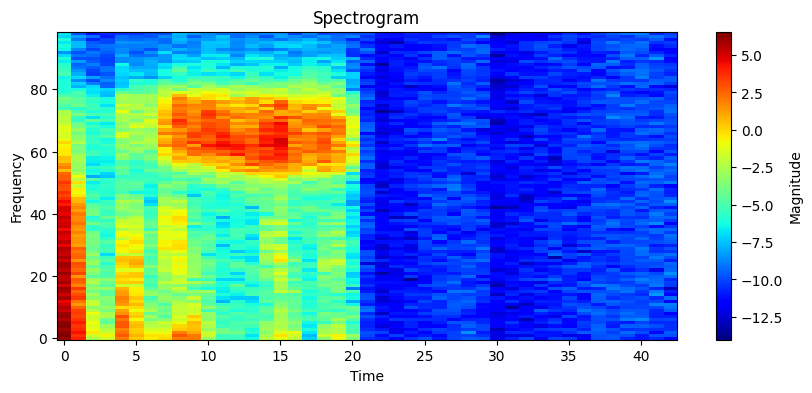

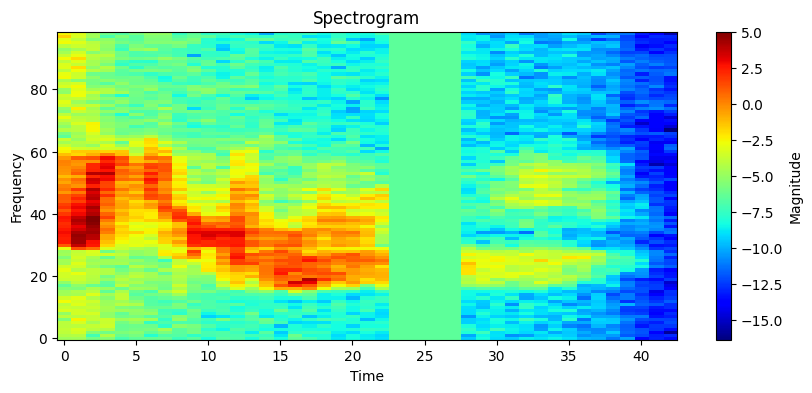

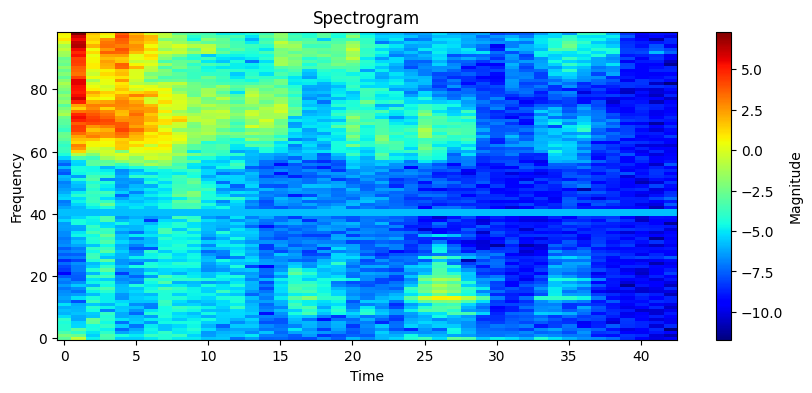

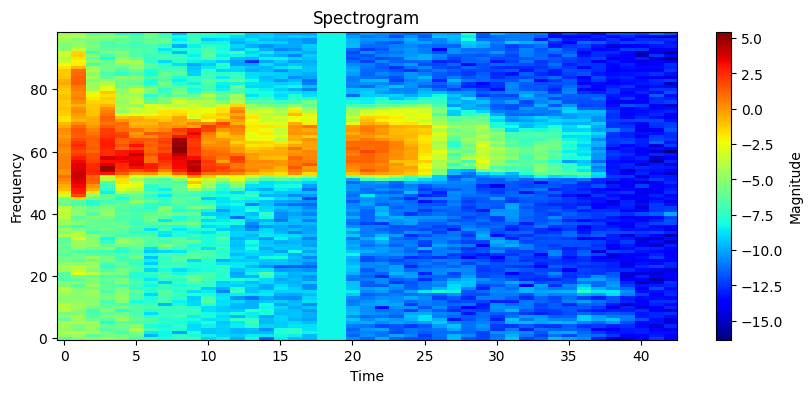

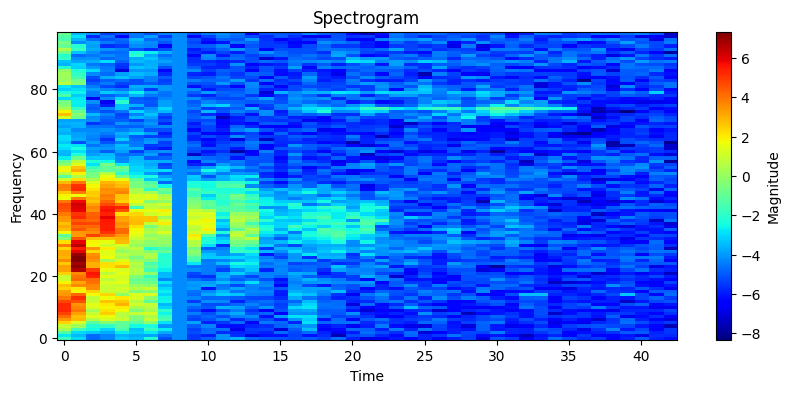

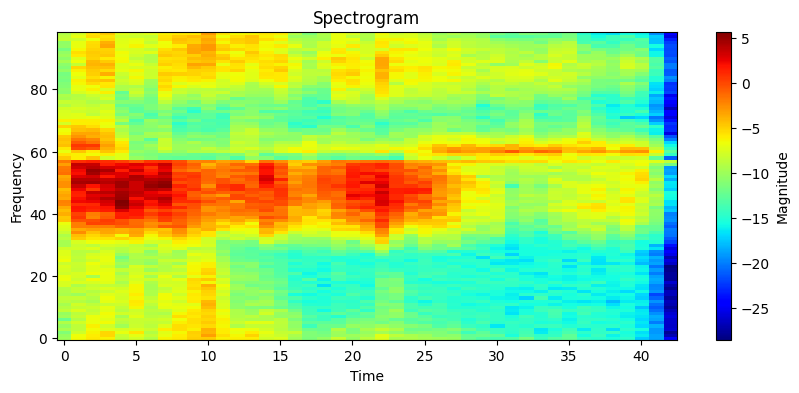

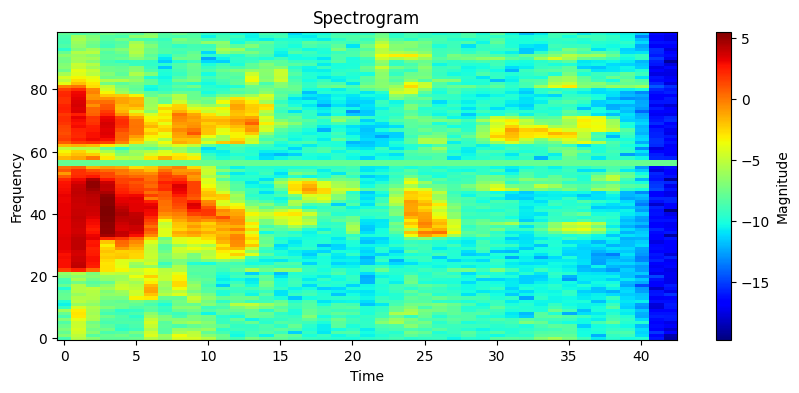

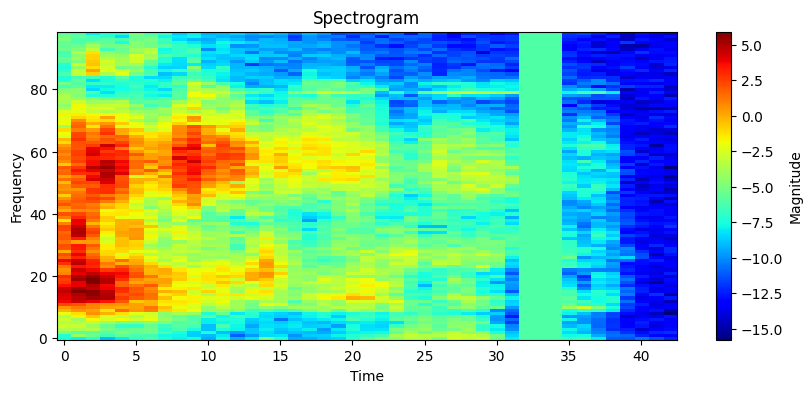

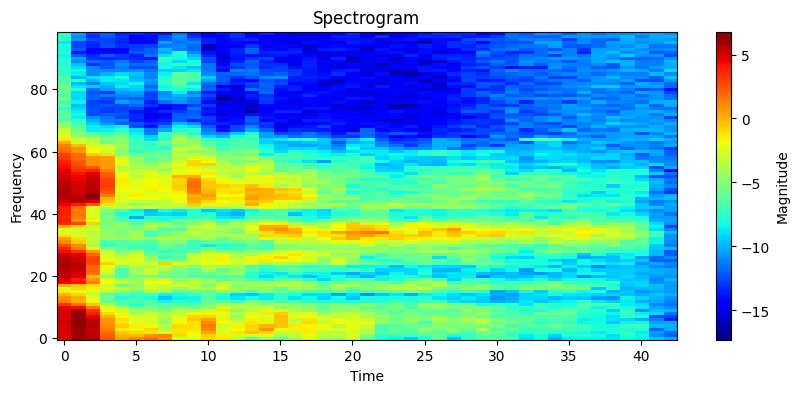

2023-04-27 15:18:29.834997: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-27 15:18:29.836722: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


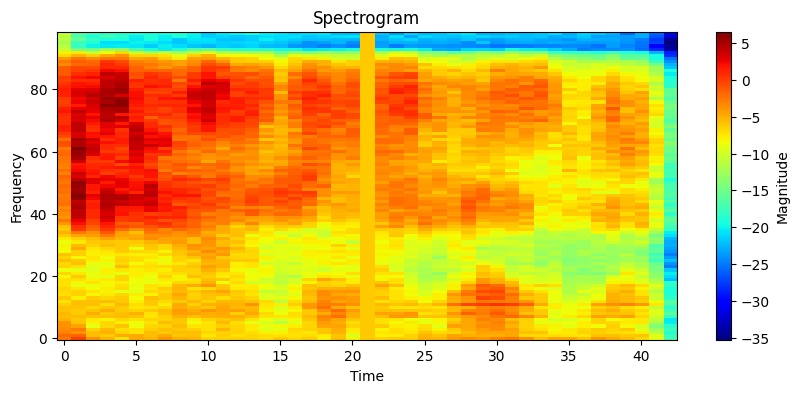

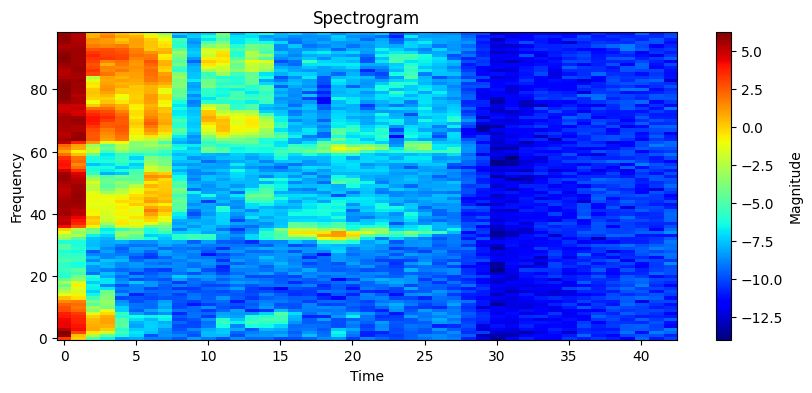

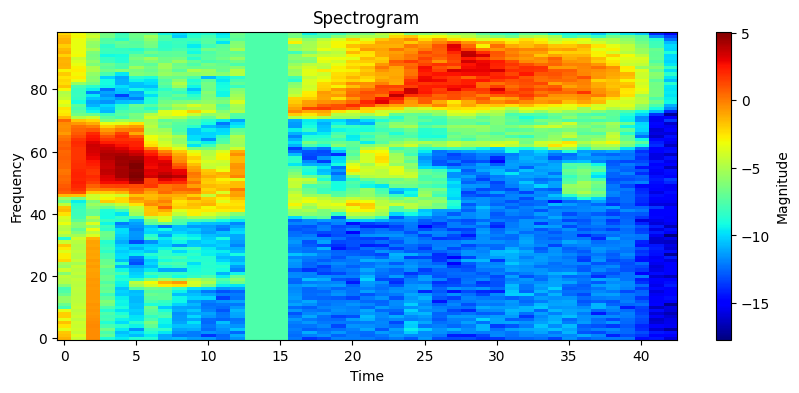

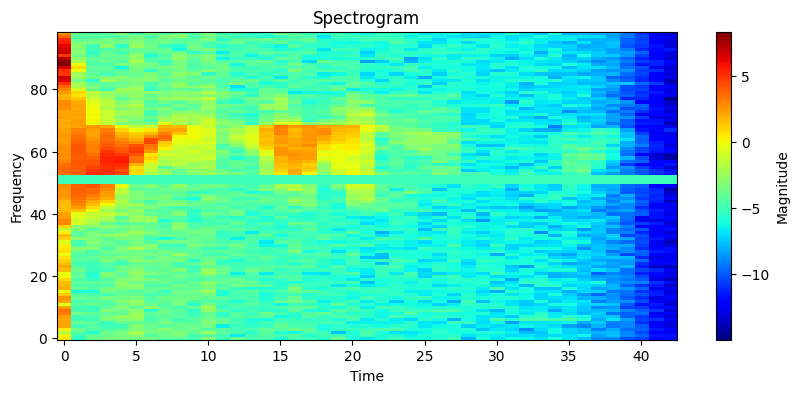

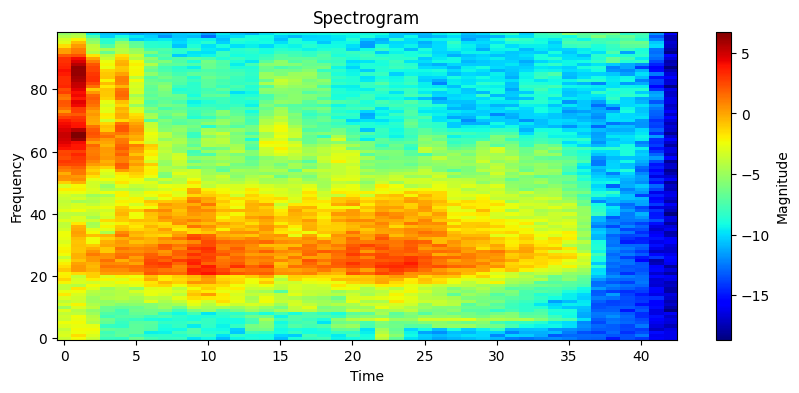

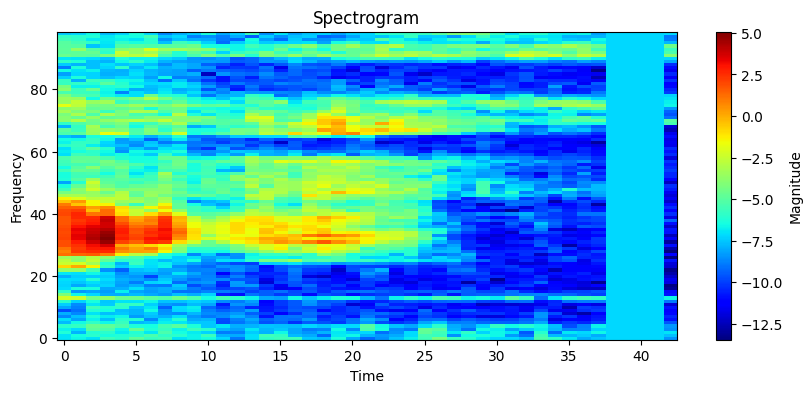

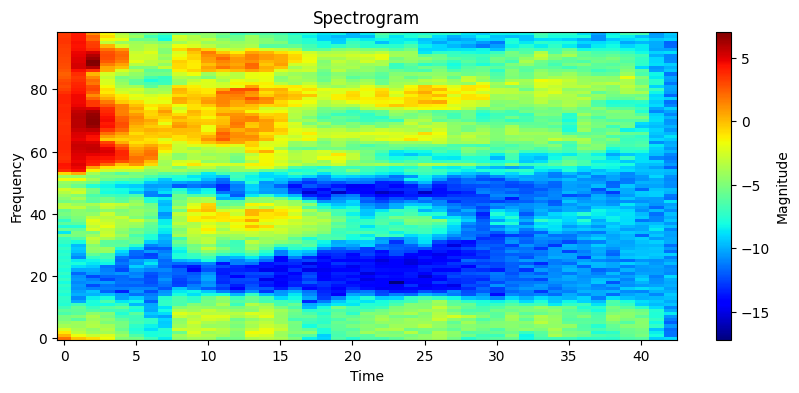

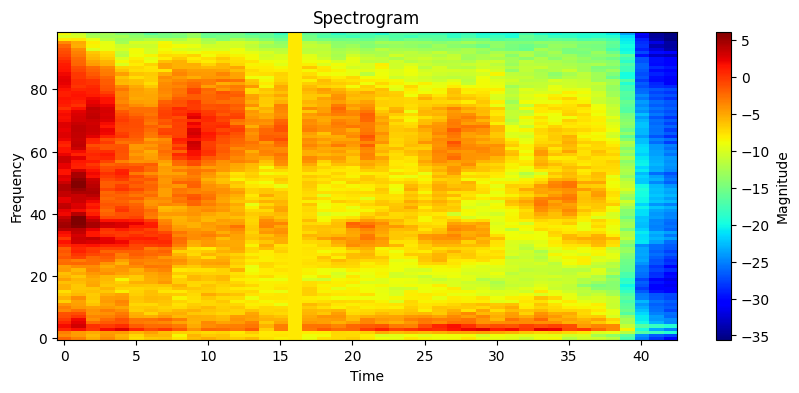

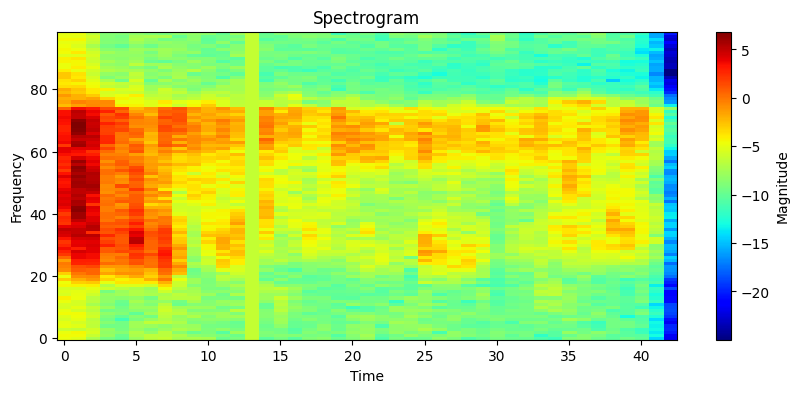

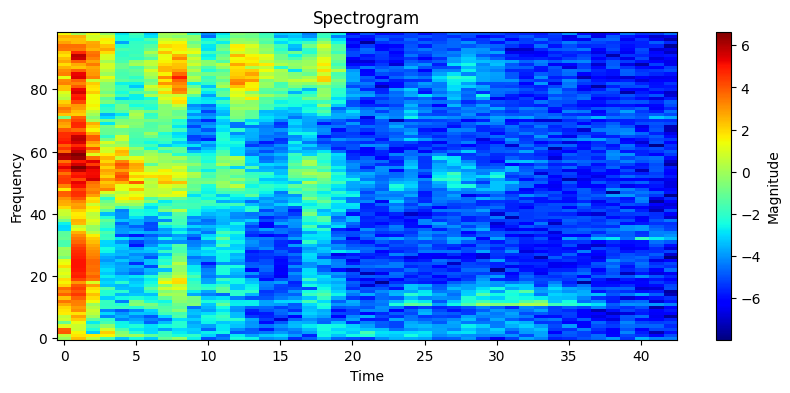

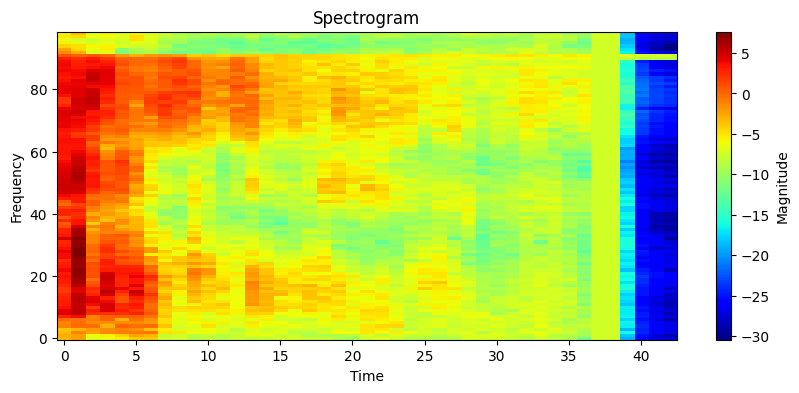

In [56]:
# # model.evaluate(test_ds)

# asdf = [0, 0, 0, 0]
# for l in train_label_ds.take(100000):
#     a = l.numpy()
#     for i in range(0, 4):
#         if a[i] == 1:
#             asdf[i] += 1

# print(asdf)

DEBUG=True
for s in train_spec_ds.take(20):
    plot_spec(s)

In [45]:

EPOCHS=30

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1)

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

history = model.fit(
    Dataset.zip((train_spec_ds, train_label_ds)),
#     validation_split=0.2,
#     train_ds,
    epochs=EPOCHS,
#     batch_size=256,
#     steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=(val_spec_ds, val_label_ds),
#     validation_steps=10,
#     callbacks=[earlystop]
)

Epoch 1/30
    749/Unknown - 21s 28ms/step - loss: 129790.6641 - accuracy: 0.4825

KeyboardInterrupt: 

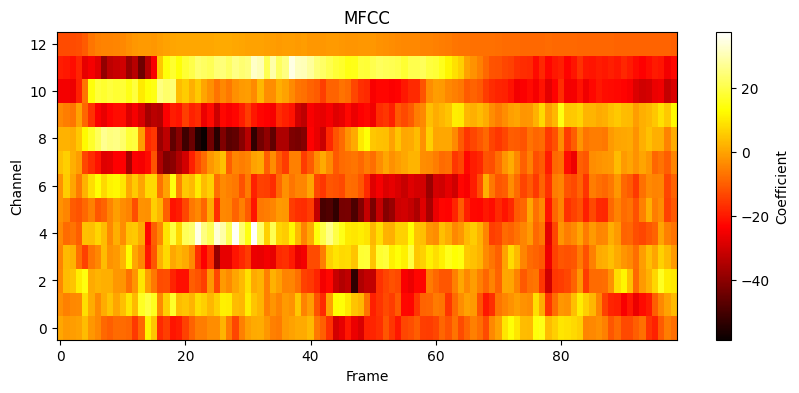

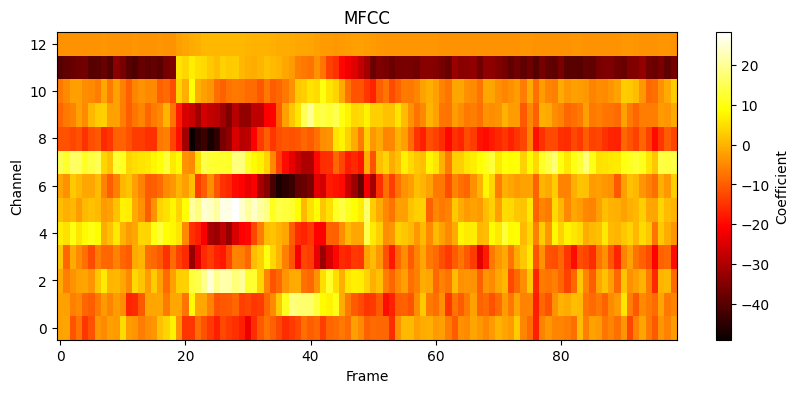

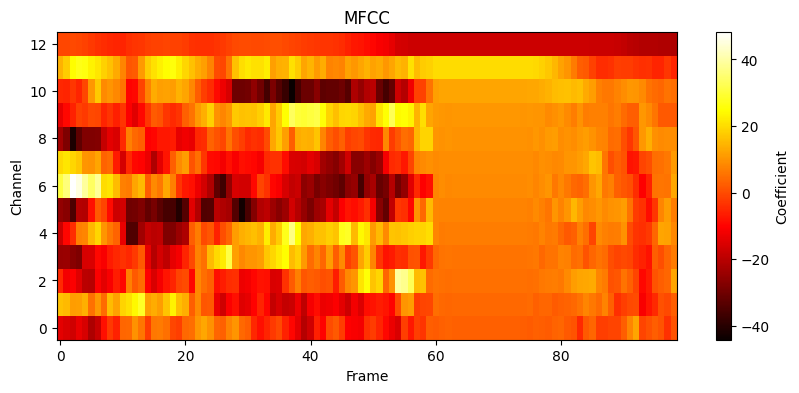

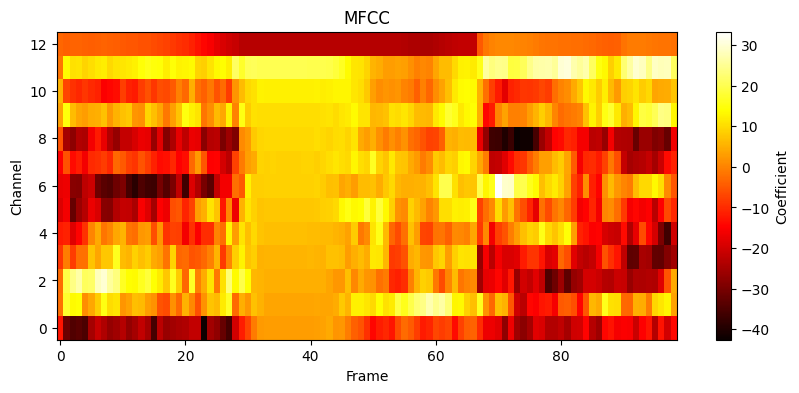

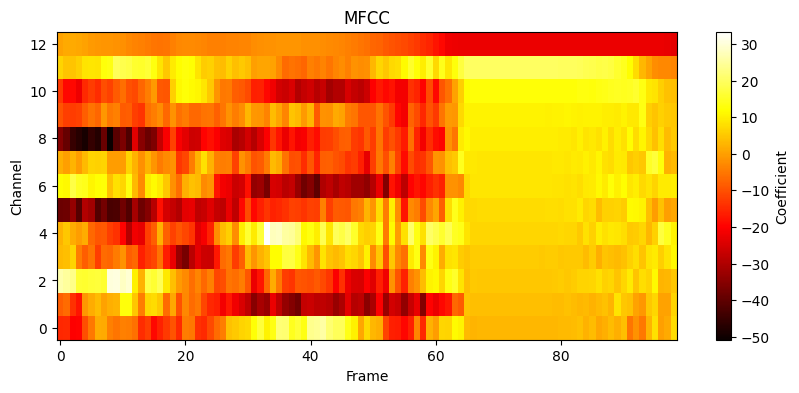

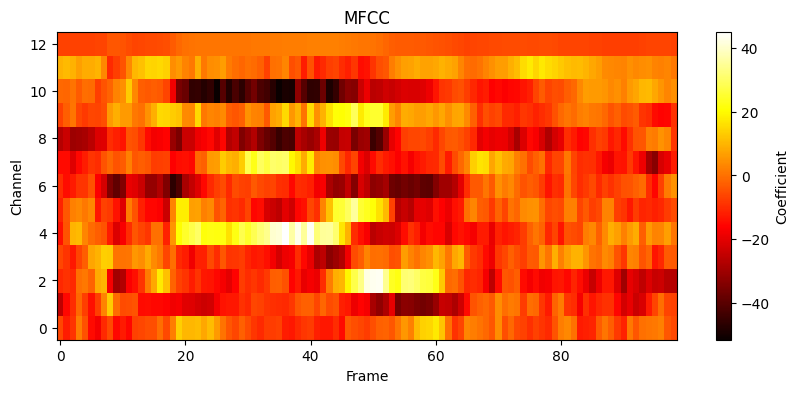

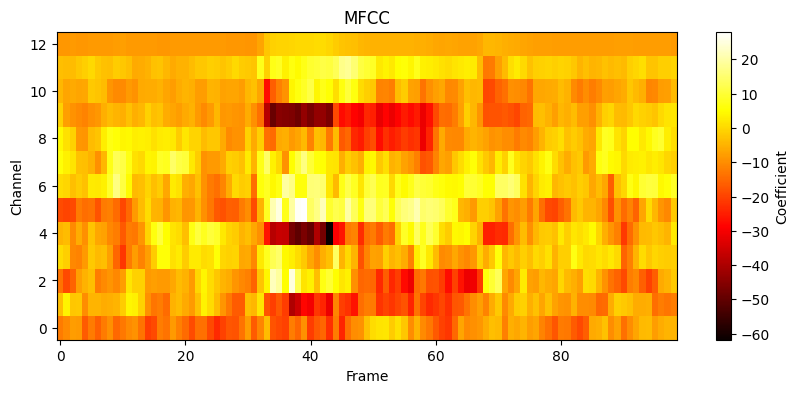

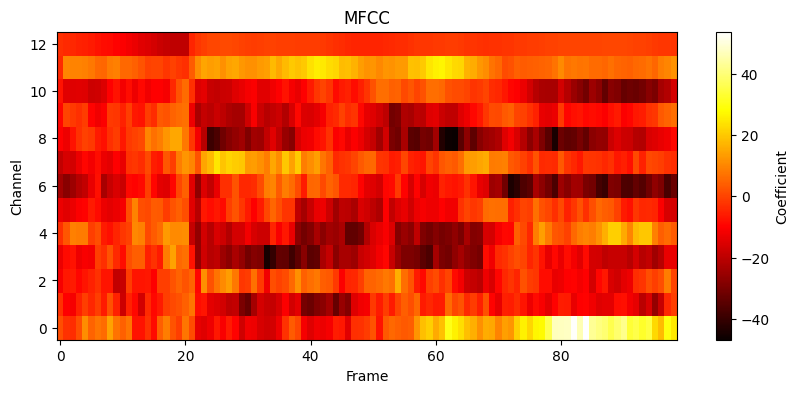

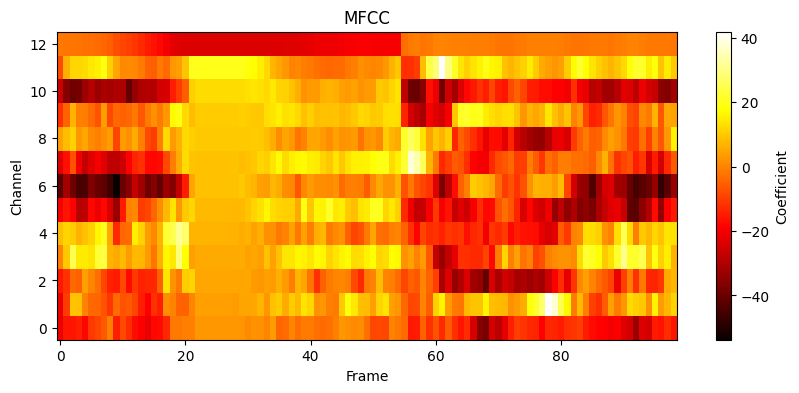

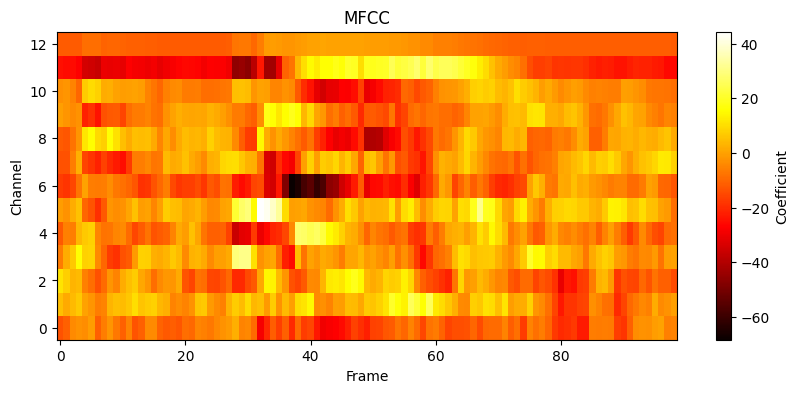

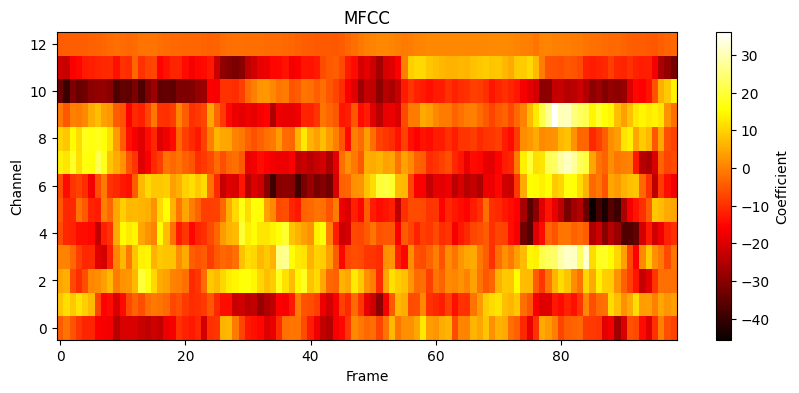

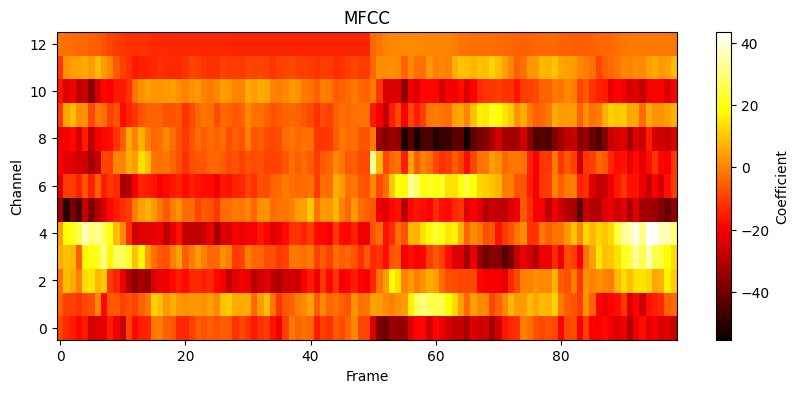

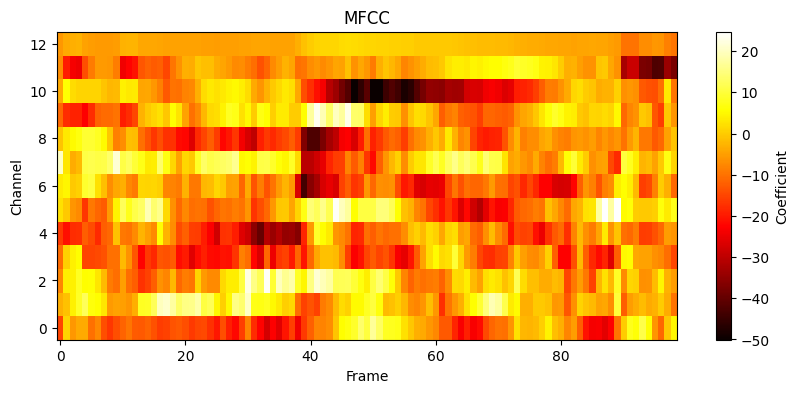

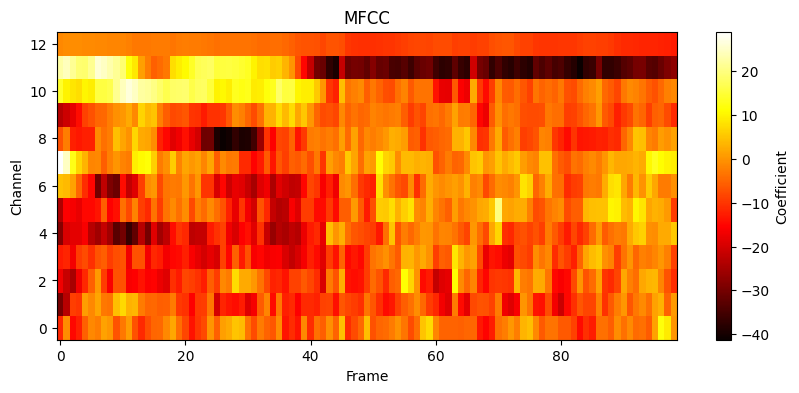

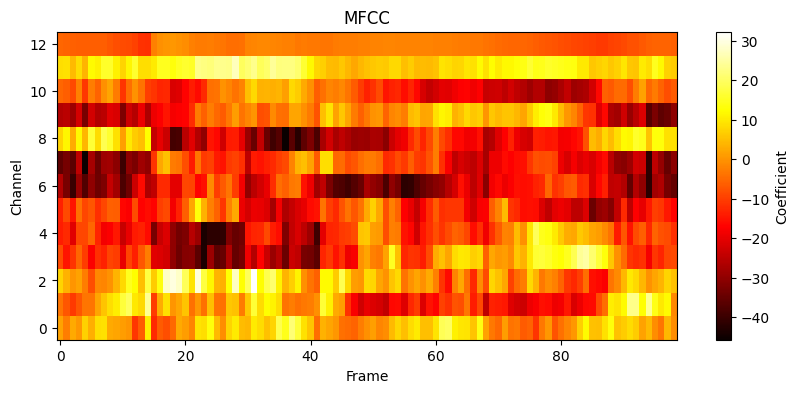

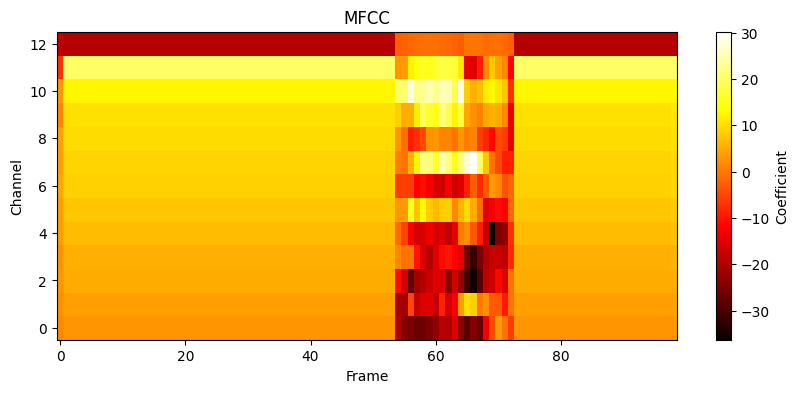

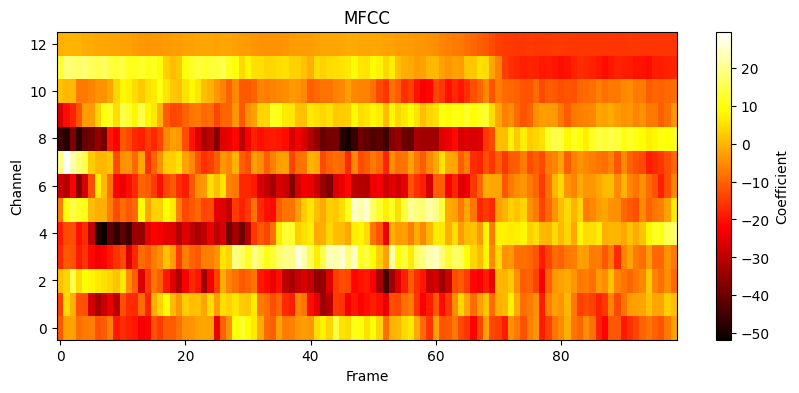

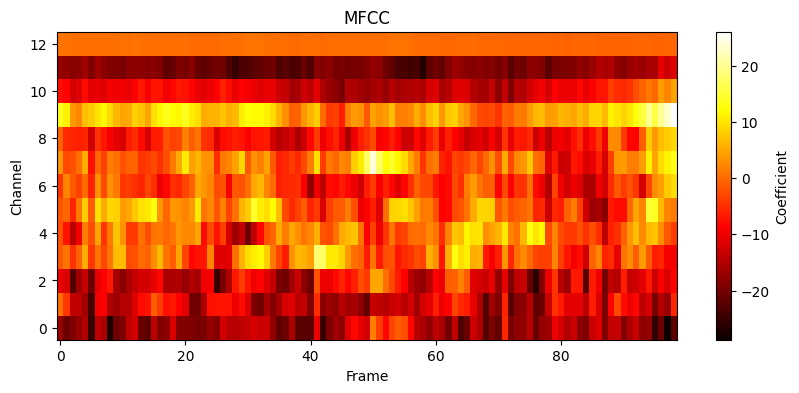

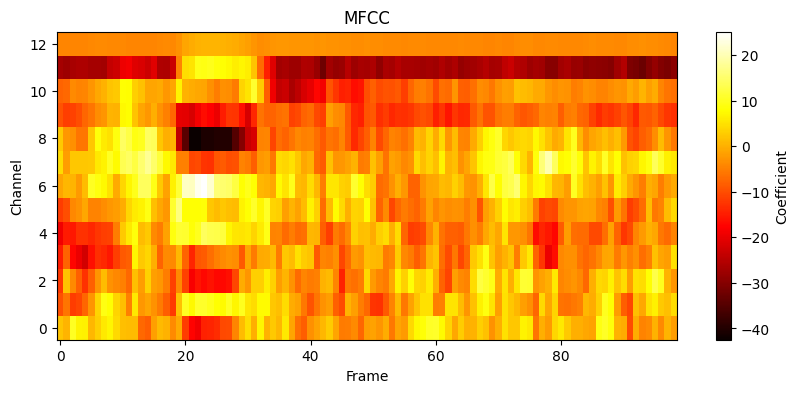

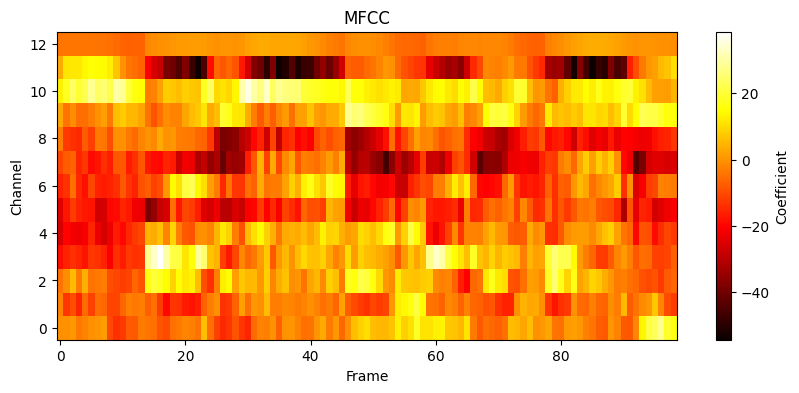

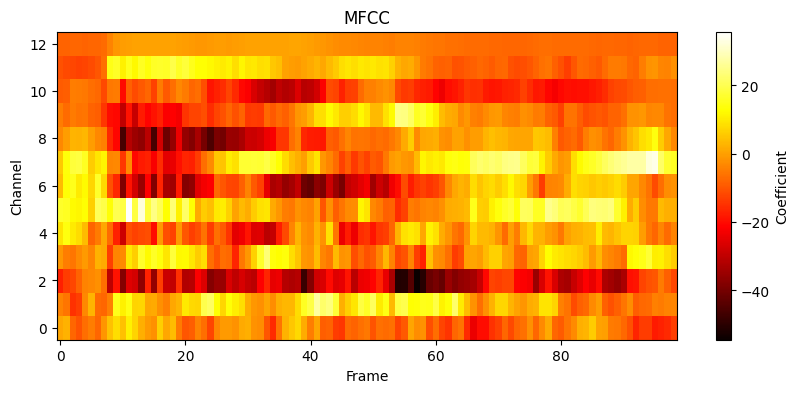

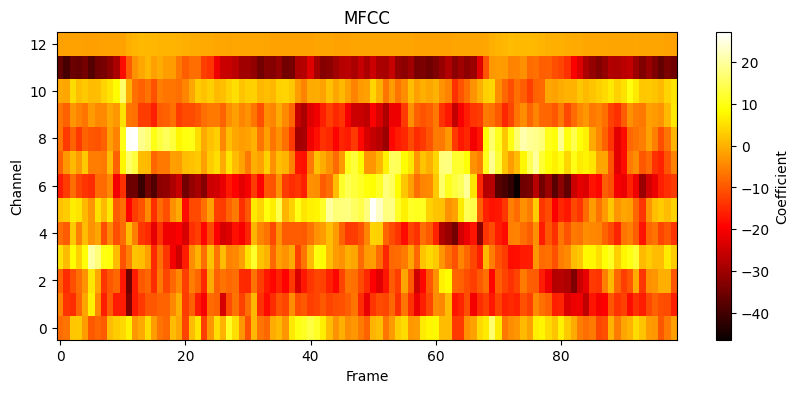

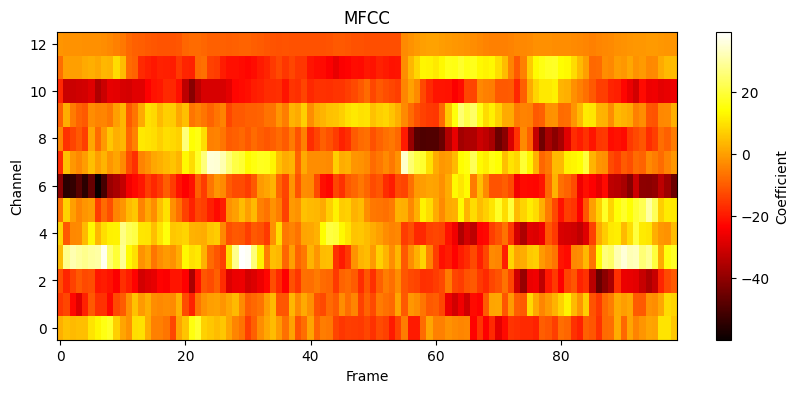

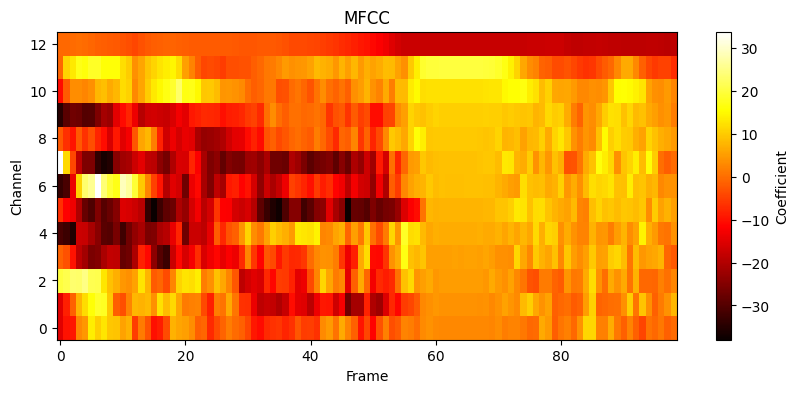

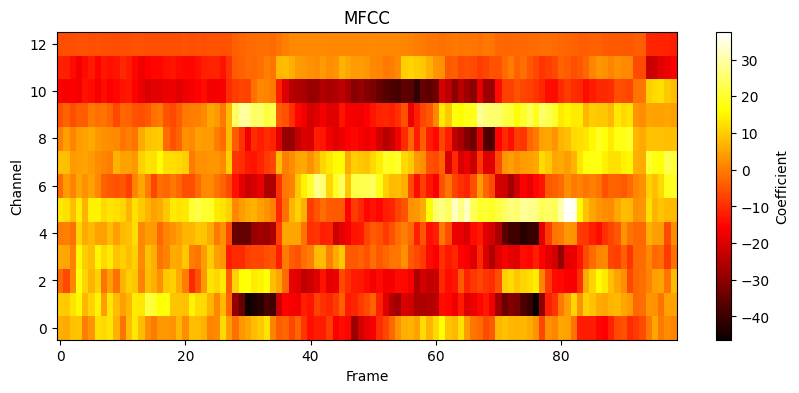

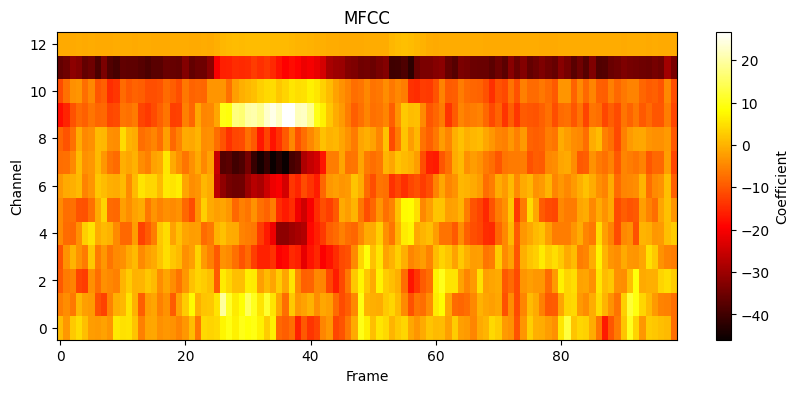

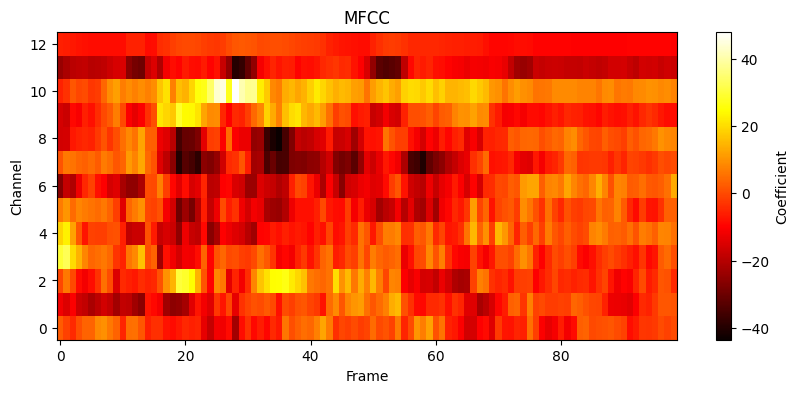

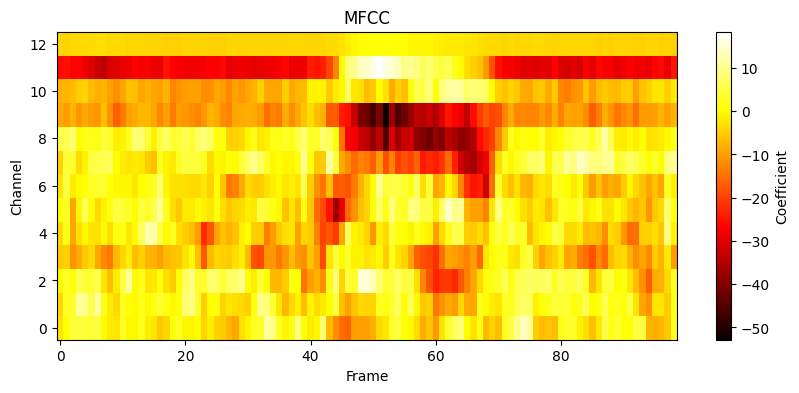

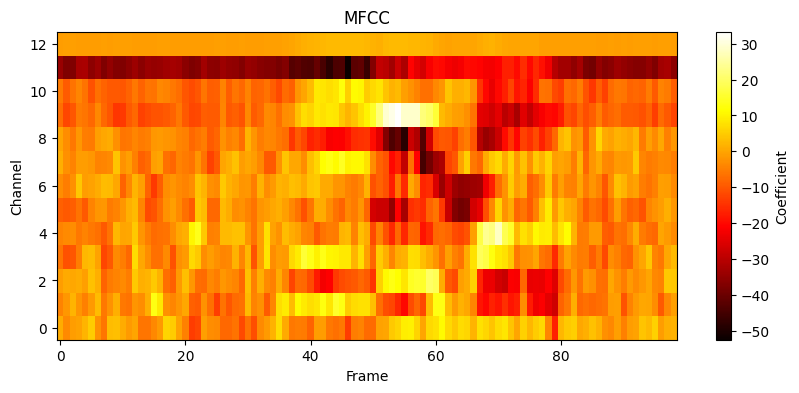

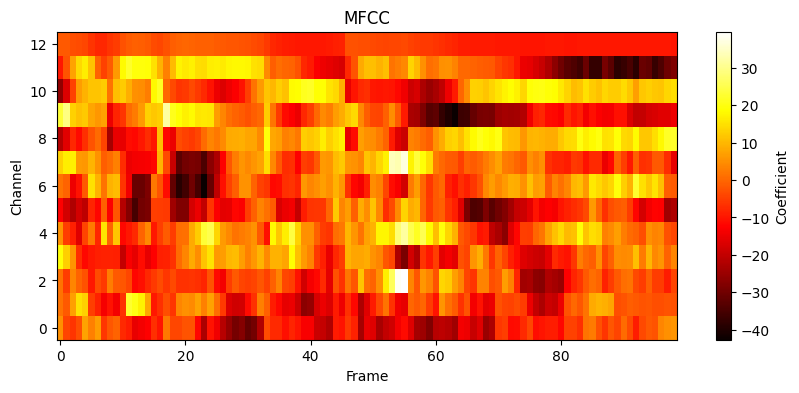

In [80]:
xxx, lll = zip(*ds)
DEBUG = True
for i in range(0, 30):
    sqqq = np.rot90(np.squeeze(xxx[i]))
    plot_mfcc(sqqq)